In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from tqdm import tqdm_notebook as tqdm
import seaborn as sb
from statsmodels.graphics.gofplots import qqplot

import sys
sys.path.append("../")

### Import our modules
from Helpers import utils
import Helpers.statistical_tests as test
from GAN import GAN as gan

%load_ext autoreload
%autoreload 2 # Reload modules before executing a cell

/Users/thibault/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Using GAN to generate Financial Time Series

## Reproducing the distribution of the VIX Index

We will first try to implement a GAN that will be able to generate time series that have the same properties as the CBOE VIX Index. Indeed the VIX has some interesting properties that are hard to replicate with standard model, due to the nature of the Index (which replicates the Volatility of the American Stock Market). To make the series stationary we consider the Log-returns of the distribution. In particular, we are interested in building a generator capable of:
* Sample from the "normal mode" of the Log-return of the series, that we could approximate as a Gaussian mode
* Sample recurring spikes, that are visible both on the raw Time Series and on its Log-returns

There is no simple tool to draw such distribution. In other projects we studied for instance Hidden Markov Models. This kind of model can be used if we consider the time series as a Markov Chain and if we make prior assumptions on the number of states (here we would intuitively set a "normal" state and a "peaky" state, or "normal/positive peak/negative peaks" state), and on the distribution of the log-returns in each state. We did not try such model here, but that would definitely be our approach if we would like to try more classical inference-based methods on this problem.

On the contrary, we are going to try some Generative Adversarial Networks architectures to solve this problem. Our hope is that every architecture uses its properties to capture relevant behaviours in the time series in order to be able to draw samples from a distribution that is as close as possible to the true one. For our experiments, we implemented most function in python scripts in order to make this notebook easier to read. 

### Download the VIX Index between 2014 and 2019

First of all, we found an online source to download the Time Series of the VIX Index. We choose to start from 2014 in order to avoid using data from the different crisis periods that occured in the past years. The Series is composed of around 1200 points, which would be enough to make statistical inference but may be light to build train samples for a deep learning model for instance. We will see later what we imagined to circumvent this problem.

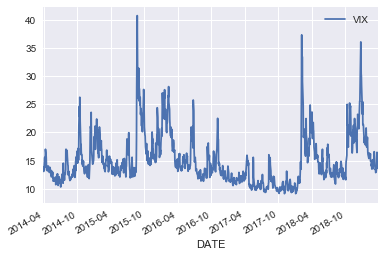

In [2]:
VIX_raw = pd.read_csv('../Datasets/VIX.csv', index_col=0, parse_dates=True, dayfirst=True)
VIX_raw.iloc[:, 0] = VIX_raw.iloc[:, 0].astype('float')
VIX_raw.plot()

We want to make the serie stationary by taking its log-returns:

$$
X_t = \text{log}(\frac{VIX_t}{VIX_{t-1}})
$$

The advantage of the log-returns is that the corresponding value between two dates $t_0$ and $t_1$ is simply the sum of the returns on every subdivision between these dates. Hence, it is quite easy to recompose the actual price of the Index from its returns:
$$
\text{log}(\frac{VIX_{t_1}}{VIX_{t_0}}) = \text{log}(\prod_{i=0}^{n-1}\frac{VIX_{t(\frac{i+1}{n})}}{VIX_{t(\frac{i}{n})}}) 
$$
For any increasing sequence of times $t(0)=t_0, t_(\frac{1}{n}),..., t_(\frac{n-1}{n}), t(1)=t_1$.

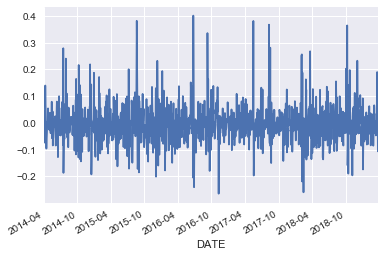

In [3]:
utils.get_data('../Datasets/VIX.csv', array=False).plot()

### Basic analysis of the distribution of the Log-return Series

We have a first look at the global distribution of the Series:

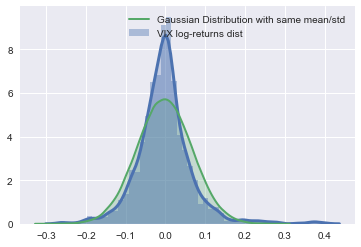

In [4]:
VIX = utils.get_data('../Datasets/VIX.csv')
m, sd = VIX.mean(), VIX.std()
sb.distplot(VIX, hist=True, kde=True, label='VIX log-returns dist', 
            kde_kws = {'shade': True, 'linewidth': 3})
sample = np.random.normal(m, sd, size=100000)
sb.distplot(sample, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2}, 
                  label = 'Gaussian Distribution with same mean/std')

We see that the distribution is clearly not gaussian, not symmetric (skewed), and leptokurtic (fat tails compared with the Gaussian). This is enough to prove the point that a Gaussian approximation would definitely fail to reproduce the properties of this distribution. 

But now we can try the same by removing the outliers. For this we simply apply a basic filter based on the standard deviation of the model.

1115 Filtered data out of 1258 original data


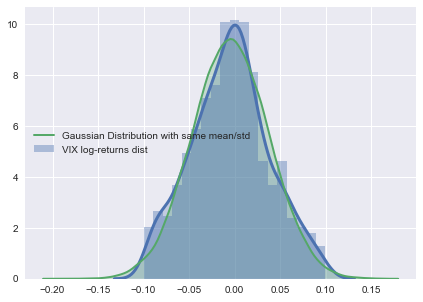

In [5]:
VIX_normal_regime = VIX[np.where(np.abs(VIX) < 0.1)]
new_mean, new_sd = VIX_normal_regime.mean(), VIX_normal_regime.std()
print('%i Filtered data out of %i original data' % (len(VIX_normal_regime), len(VIX)))
plt.figure(figsize=(7, 5))
sb.distplot(VIX_normal_regime, hist=True, kde=True, label='VIX log-returns dist', 
            kde_kws = {'shade': True, 'linewidth': 3})
sample = np.random.normal(new_mean, new_sd, size=100000)
sb.distplot(sample, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2}, 
                  label = 'Gaussian Distribution with same mean/std')

It is quite impressive to see how removing only around $10\%$ of the data makes the new distribution very close to a Gaussian distribution. We provide QQ-plots to compare these distributions' quantiles with the ones of the Gaussian distribution. There are of course border effects for the filtered distribution, but the quantiles are much closer to the identity curve otherwise.

VIX Log-returns QQ-plot


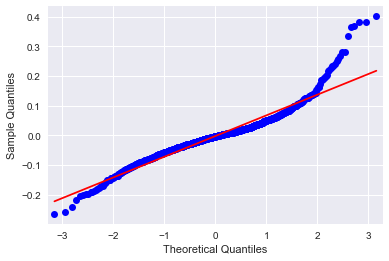

Filtered log-returns QQ-plot


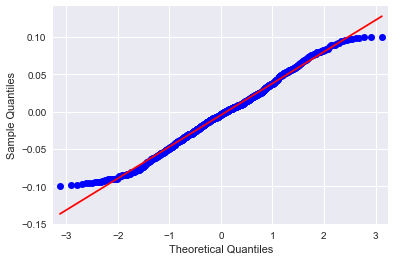

In [6]:
print('VIX Log-returns QQ-plot')
qqplot(VIX, line='s')
plt.show()
print('Filtered log-returns QQ-plot')
qqplot(VIX_normal_regime, line='s')
plt.show()

Now we are interested in the distribution of the negative and positive peaks. As there are much fewer points it is harder to make a good assumption, but with the figures below we suggest to either consider these peaks as shifted exponential distribution, or as Gamma distribution (to attenuate the impact of the choice of the threshold).

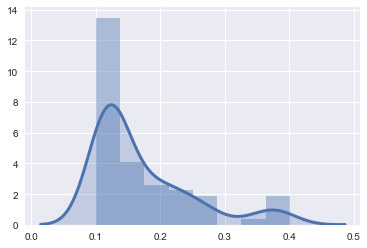

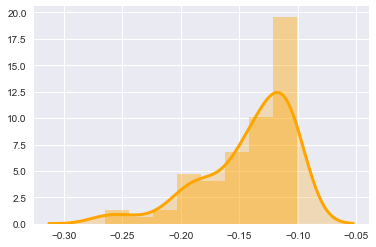

In [7]:
peaky_VIX = VIX[np.where(np.abs(VIX) > 0.1)]
sb.distplot(peaky_VIX[peaky_VIX>0], hist=True, kde=True, label='VIX log-returns dist on positive peaks', 
            kde_kws = {'shade': True, 'linewidth': 3})
plt.show()
sb.distplot(peaky_VIX[peaky_VIX<0], hist=True, kde=True, label='VIX log-returns dist on negative peaks', 
            kde_kws = {'shade': True, 'linewidth': 3}, color='orange')

Our last piece of analysis in this part consists in checking the adequacy of the VIX time series with the stylized facts about financial time series we detail in our pdf report.  
The facts we check below are:
* Stationarity of the Return Series (the raw Series is clearly non stationay so we don't check it)
* Uncorrelation of the Log-returns
* Autocorrelation of squared Log-returns
* Skewness and Leptokurticity

In [8]:
print('Stationarity Test for returns')
test.is_stationnary(VIX, '5%', display_stats=True)
print('__________________________________')
print(' ')
print('Autocorrelation Test on Log-returns')
test.check_autocorel(VIX, 10, 0.05,
                     qstat=True, score_min=0.8, display_stats=True)
print('__________________________________')
print(' ')
print('Autocorrelation Test on squared Log-returns')

test.check_autocorel(VIX**2, 10, 0.05,
                     qstat=True, score_min=0.8, display_stats=True)
print('__________________________________')
print(' ')
print('Computation of the moments of log-returns')
test.get_moments(VIX)

Stationarity Test for returns
ADF Statistic: -11.715874
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
__________________________________
 
Autocorrelation Test on Log-returns
Autocorrelations: [ 1.         -0.0220979  -0.0447664  -0.0027459  -0.05583679 -0.04933308
 -0.05925662 -0.0252395  -0.04346091 -0.0364005   0.02391487]
Confidence intervals: [[ 1.00000000e+00  1.00000000e+00]
 [-7.73575083e-02  3.31617003e-02]
 [-1.00052981e-01  1.05201825e-02]
 [-5.81430586e-02  5.26512598e-02]
 [-1.11234368e-01 -4.39218054e-04]
 [-1.04902242e-01  6.23608852e-03]
 [-1.14959360e-01 -3.55387241e-03]
 [-8.11344048e-02  3.06554042e-02]
 [-9.93906100e-02  1.24687814e-02]
 [-9.24332266e-02  1.96322282e-02]
 [-3.21900204e-02  8.00197586e-02]]
Q stats of Ljung Box test: [ 0.61576936  3.14486863  3.1543917   7.09528413 10.17404901 14.6195484
 15.4267005  17.82188455 19.50340993 20.22980454]
p-values: [0.43262378 0.20753935 0.3684281  0.13093776 0.0704512  0.02343139
 0.03090255 

(-0.0025205029265861064,
 0.06962744234835493,
 0.9320535918979757,
 5.157252114548843)

Our stationarity test is an Augmented Dickey Fuller test. The null hypothesis states that there is a unique root in the time series, which is strongly rejected here, so the hypothesis stationarity is not rejected by this test.

The autocorrelation is trickier to analyze because results are often quite unstable with this kind of test. However, our results seem to be in favour of the stylized facts. Indeed even if the non-autocorrelation cannot be rejected at a $5\%$ confidence level for every term, it is at a $1\%$ condidence level. And we see that when they are value 0 is always on the confidence interval or one of the boundaries is really small. For this reason, we would interpret these results as a good indicator that the returns are uncorrelated. On the other hand, for the squared returns the null hpyothesis (stating that a coefficient is 0) is strongly rejected at each time window.

To conclude this analysis by the moments: we verify that the Log-return Series has a positive skewness ($0.93$) and is clearly leptokurtic: its kurtosis is 5 points in excess of the Normal distribution kurtosis (which is 3).


Now that we verified  these facts, we can use the test we implemented as another base to evaluate our different generating models. We can now skip to the Deep Learning part of our project with the experimental setup for training our GAN models.

## Implementation of Generative Adversarial Networks

### Batch generator

The first task is to determine a way to draw training samples from our real distribution. This is not an easy task because of the limited amount of available data (1200 in our case), as we want to both get realistic and diverse samples.

To tackle this problem, our first idea is to focus on the problem of generating sequences of a given length. Our base windows are 60, 125 and 250 days, which roughly correspond to 3 months, 6 months and a year in terms of trading days. Then, an intuitive idea to draw sample is to randomly choose a start and a sequence of the right length from this point. This idea is able to provide a reasonable sample size. 

However, the given samples may lack some diversity as there are only a few peaks available in the whole sequences (we before considered around 100 points as peaks). As we do not want our network to learn exactly the value of the peaks, we mays want to add some diversity in the sample. To achieve this, we can use "Data Augmentation" methods. We used the simplest one in practice: adding some noise into real samples. The noise needs to be calibrated in order to keep the data structure, i.e it has to be small compared with the real standard deviation. A more precise method could be to keep the separation of the Series in three states as before, and add a different kind of noise for each state. Hence we could preserve the separation between peaks and normal data.

A last idea could be to completely guide the model by training the model with mixed real/generated samples. The samples could be drawn from a simple statistical model. In our case we could calibrate a simple mixture of Gaussian distributions for the normal state and two Gamma distributions for the peaky states. Unfortunately we did not have enough time to implement these methods. We can also add that this simple generator could also be a benchmark for our more complex algorithms!

In the next cell we just plot a batch generated with the method described above for a window of 125 days.

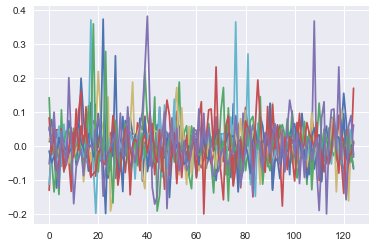

In [9]:
batch = utils.generate_batch(VIX, 125, 10)
plt.plot(batch.numpy().T)

## GAN

In our code we implemented different kinds of GAN architectures, with blocks composed for instance of:
* Fully connected layers 
* Convolutional layers
* LSTM layers
We tried to generally get the same kind of architecture for the Generator and the Discriminator (and not combine a convolutional generator and a LSTM discriminator for example, which would make little sense). The interested reader may refer directly to our source code files to get a deeper overview of our architectures. We show on the cell below the training of a GAN using fully connected layers for the generator and the discriminator.

step 0: discriminator: 1.386e+02, generator: -7.156e+01


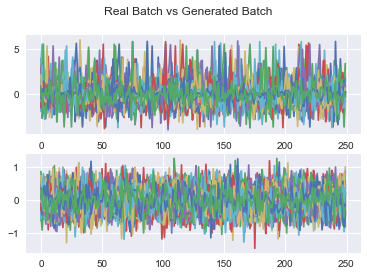

step 50: discriminator: 1.196e+02, generator: -6.581e+01
step 100: discriminator: 1.301e+02, generator: -6.117e+01


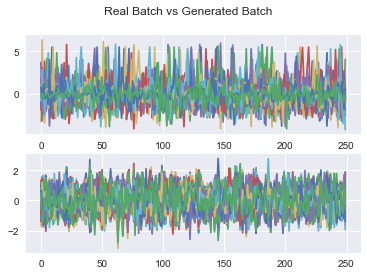

step 150: discriminator: 1.356e+02, generator: -6.528e+01
step 200: discriminator: 1.355e+02, generator: -6.667e+01


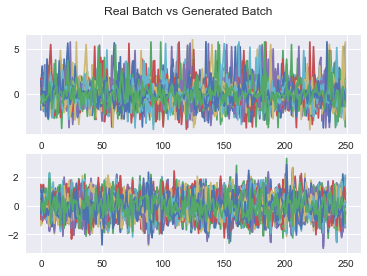

step 250: discriminator: 1.374e+02, generator: -6.873e+01
step 300: discriminator: 1.378e+02, generator: -6.856e+01


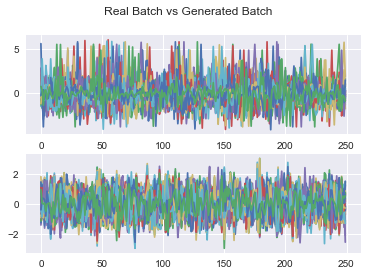

step 350: discriminator: 1.383e+02, generator: -6.996e+01
step 400: discriminator: 1.376e+02, generator: -6.818e+01


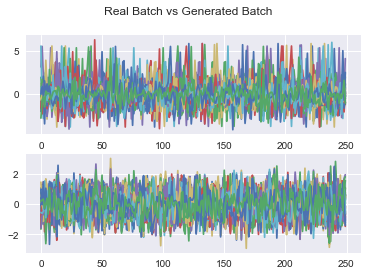

step 450: discriminator: 1.376e+02, generator: -7.138e+01
step 500: discriminator: 1.368e+02, generator: -6.830e+01


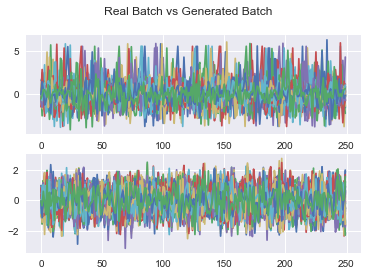

step 550: discriminator: 1.383e+02, generator: -6.856e+01
step 600: discriminator: 1.373e+02, generator: -6.790e+01


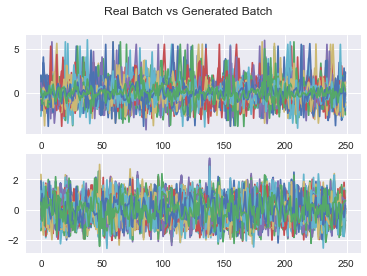

step 650: discriminator: 1.379e+02, generator: -6.897e+01
step 700: discriminator: 1.394e+02, generator: -6.868e+01


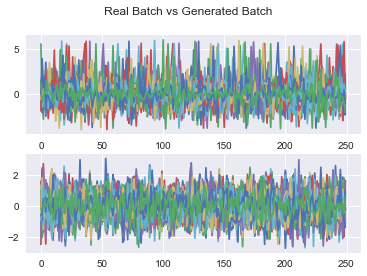

step 750: discriminator: 1.368e+02, generator: -6.656e+01
step 800: discriminator: 1.357e+02, generator: -6.677e+01


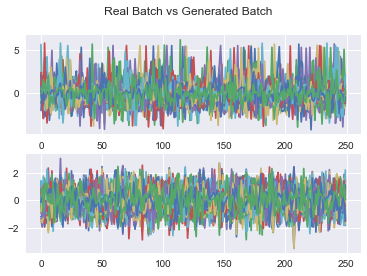

step 850: discriminator: 1.370e+02, generator: -6.893e+01
step 900: discriminator: 1.372e+02, generator: -6.784e+01


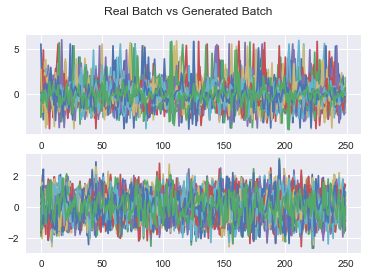

step 950: discriminator: 1.363e+02, generator: -6.817e+01
step 1000: discriminator: 1.361e+02, generator: -6.823e+01


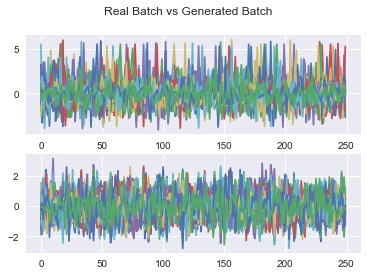

(Generator(
   (fc1): Linear(in_features=20, out_features=1000, bias=True)
   (hidden_layers): ModuleList(
     (0): Linear(in_features=1000, out_features=1000, bias=True)
     (1): Linear(in_features=1000, out_features=1000, bias=True)
     (2): Linear(in_features=1000, out_features=1000, bias=True)
     (3): Linear(in_features=1000, out_features=1000, bias=True)
     (4): Linear(in_features=1000, out_features=1000, bias=True)
     (5): Linear(in_features=1000, out_features=1000, bias=True)
     (6): Linear(in_features=1000, out_features=1000, bias=True)
     (7): Linear(in_features=1000, out_features=1000, bias=True)
     (8): Linear(in_features=1000, out_features=1000, bias=True)
     (9): Linear(in_features=1000, out_features=1000, bias=True)
   )
   (fc2): Linear(in_features=1000, out_features=250, bias=True)
   (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (bn_out): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [11]:
from Architectures.Lin_GAN import *
from Architectures.Lin_GAN import Generator as LG
from Architectures.Lin_GAN import Discriminator as LD

param = {
    'serie': VIX,
    'window': 250,
    'frame': 50,
    # Display options
    'frame_plot': 100,
    'is_notebook': True,
    'batchlen_plot': 50,
    'plot': True,
    # Base class of the Generator and Discriminator
    'Generator': Generator,
    'Discriminator': Discriminator,
    # Training parameters
    'N_ITER': 1001,
    'TRAIN_RATIO': 5,
    'BATCHLEN': 100,
    'generator_args': {
    # Random Noise used by the Generator
    'PRIOR_N': 20,
    'PRIOR_STD': 1.,
    # Depth and Withdraw of Hidden Layers
    'WDTH': 1000, 
    'DPTH': 10},
    'discriminator_args': {
    # Depth and Withdraw of Hidden Layers
    'WDTH': 100,
    'DPTH': 5},
    # Adam Optimizer parameters for Generator/Discriminator
    'lr_G': 1e-4,
    'betas_G': (0.5, 0.9),
    'lr_D': 1e-4,
    'betas_D': (0.5, 0.9),
    # Stopping/Saving options
    'time_max': 1200,
    'save_model': False,
    'save_name': 'Lin_G_'+str(int(np.random.uniform()*1e9))
}

gan(**param)

Let's explain what happens in the previous cell. First of all, ```gan``` is a generic function that we implemented to train all of our GAN algorithms. This function is very useful because the training process does not change for each algorithm. However, to make it as adaptable as possible we provided a lot of parameters to this function.

First, note that the function does not return anything: when testing the model we can choose to display the losses at each ```frame``` iteration, and to plot ```batch_plot``` generated Time Series along with the same number of real samples at each ```frame_plot``` iteration. The purpose of the function is to save the parameters of the trained model when ```save_model``` is set to True. The generator, discriminator and parameters state_dictionnaries are then saved in different folder with ```save_name``` as a common key to link them together when we want to download the models again.

About the general parameters of the model, we can put any time series as input in ```serie``` (so it can be trained for other time series than the VIX). We also define the number of generator epochs ```N_iter```. For each generator epoch, there are ```TRAIN_RATIO``` discriminator epochs. The idea that the discriminator has to been trained more than the generator is quite classical in GAN litterature, however we generally do not need to set a too large traning ratio in practice. ```BATCHLEN``` is the size of the batch (i.e number of samples) drawn for each training task. For the discriminator this is the size of both real and generated samples.

The other parameters are specific to the GAN architecture. ```Generator``` and ```Discriminator``` are some classes refering to some generator/discriminator architecture, that all have the same attributes (refering to different implementation). An instance of these class is defined at the beginning of the ```gan``` function, initialized with ```generator_args``` and ```discriminator_args```. These dictionnaries are very class specific, in this case (fully connected layers) the parameters are about the depth of the network, the size of each layer and the size and standard deviation of the generated noise. Finally, some parameters set the Adam optimizer used during the backpropagation steps. 

Before jumping to the next step we can have a look at the results of the toy model above. Indeed, we see that the model above was never able to reach the spikes distribution during the process. However, we can clearly see that it was able to get the distribution of the "nearly gaussian" underlying state.

Even with the simple fully connected layers model it may be very hard to find good parameters and to determine which way to look for them. For this reason we used quite a brutforce method: we defined a grid for each parameter that seemed of interest to us and we let our computer run for hours to get results for a diverse number of parameter's combinations.

# Experiments with Pre-Trained models

From now on we only use models that were pre-trained before writing this notebook. We wrote some functions in ```utils``` to be able to download everything about these models using only the random name reference attributed during the training. We start with the Fully Connected Layers models, for which we could compute up to 500 models.

# Fully Connected Layers for Generator and Discriminator

We propose to start with a first cell that shows how to download a model and use it to generate some sample. The name must correspond to a pickle file in *Parameters* folder, and to torch ``state_dict`` files in *Generator* and *Discriminator*.

In [ ]:
from Lin_GAN import *
from Lin_GAN import Generator as LG
from Lin_GAN import Discriminator as LD
name = 'Lin_G_413575134'
G, D, param_name = utils.load_models(name, LG, LD)
print(param_name)
plt.plot(G.generate(5).detach().numpy().T)
plt.show()

These functions are a good help if we want to analyze the visual quality of the generator outputs. However, as we mentionned above we have to look at the performance of 500 models. For this reason, we need to find a metric that would allow us to rank these models such as the model with higher ranks have a larger probability to present some interest to us. 

For this, we used a criteria that we have not introduced yet: Kullback-Leibler Divergence. We choose this metric because it is a widely used method to efficiently compare two probability distributions. Assume that the samples at hand from the VIX index gives sufficient informations about its real underlying distribution $\mathbb{Q}$. Now assume that the probability distribution of each value of the generator output is $\mathbb{P}$. The KL-div computes a "distance between" these two distribution such as:
$$ KL(\mathbb{Q} || \mathbb{P}) = \mathbb{E}_\mathbb{P}(\text{log}(\frac{\mathbb{Q}(.)}{\mathbb{P}(.)}))$$

This metric is always positive and is 0 only if the true distribution are identical. So our criteria could be to minimize the value of the KL-divergence between the generator distribution and the "real" distribution.

The problem is of course that we do not the theoretical value of the true distribution, and not even the one of the generator (even for simple architectures it is very hard to compute). So we have to work with a Kernel estimation of the densities (kde in python), assuming that we can draw representative samples. These KDE are then used to compute an empirical KL-divergence. 

So our procedure here is simple: download each model and compute their empirical KL-divergence with Real Samples. After that we will implement further analysis for the models with the lowest KL-divergence, and look after similarities between their parameters. Indeed, the KL-divergence computation is not sufficient to compare the models as the Time Series aspect is completely forgotten in this metric. Moreover, KL-divergence would also be unable to detect model collapse because in our problem the mode on which the samples collapse is a given time series that can be multiplied by a certain positive or negative factor.

Downloading the models:

In [ ]:
import os
available_param = os.listdir('Parameters')
name_list = []
for x in available_param:
    name_list.append(x[:-3])

In [ ]:
gen = {}
param = {}
disc = {}
for name in tqdm(name_list):
    try:
        G, D, param_name = utils.load_models(name, LG, LD)
        gen[name] = G
        disc[name] = D
        param[name] = param_name
    except:
        print('file {} not found'.format(name))
        pass

In [ ]:
name_window = {'3M': [], '6M': [], 'Y': []}
for name in param.keys():
    wdw = param[name]['window']
    if wdw == 60:
        name_window['3M'].append(name)
    elif wdw == 125:
        name_window['6M'].append(name)
    elif wdw == 250:
        name_window['Y'].append(name)
    else:
        print('Unexpected window: {}'.format(wdw))
print([(key, len(name_window[key])) for key in name_window.keys()])

As one can see we implemented models for three different windows: 3 Months (60 days), 6 Months (125 days) and 1 year (250 days). Our goal is too check whether the window size has an influence on the general performance of the models or not. We can now compute the empirical KL divergences for each model and rank them:

In [ ]:
from utils import get_KL_div_list
n0, l0 = get_KL_div_list(VIX, '3M', 10, name_window, LG, LD)
n1, l1 = get_KL_div_list(VIX, '6M', 10, name_window, LG, LD)
n2, l2 = get_KL_div_list(VIX, 'Y', 10, name_window, LG, LD)

In [ ]:
order_60 = np.argsort(l0)
order_125 = np.argsort(l1)
order_250 = np.argsort(l2)
plt.plot(np.sort(l0)[:20], label='3M')
plt.plot(np.sort(l1)[:20], label='6M')
plt.plot(np.sort(l2)[:20], label='1Y')
plt.legend()

## Analysis of some models 

If this part we are going to pick some models among the better ranked using KL divergence criteria and to analyze their performance comparing with real samples. For this analysis we can use different tools, namely:
* Visual quality of the samples (note that we normalized all series), in comparisons with real samples and Gaussian samples
* Statistic comparison and adequation with the stylized facts about the time series (that we checked in a previous part)
* Performance of a Support Vector Classifier on separating real samples from fake ones

The interest of the last method is to use an algorithm that was not involved in the training of the model (contrary to the discriminator), to check if another representation of the data can clearly separate both samples. The interest of SVC is that it projects the samples in high dimensional linear spaces, hence it performs multiple combinations of the inputs and so we can hope that it will learn alone a high level representation of the data without much pre-processing.

In [ ]:
%autoreload
from utils import compare_plots

### 3 Months window

#### Example 1)

In [ ]:
name_best = n0[order_60[0]]
compare_plots(name_best, serie=VIX, batchlen=20, window=60, Gen=LG, Disc=LD)

This first example is very interesting because it perfectly illustrates the failure of KL-divergence as a possible single criteria to evaluate the quality of a sample. Indeed, we observe here an almost perfect example of mode collapse. As I explained before, the mode collapse is characterized in our setup by the fact of always generating the same time series up to a scaling factor.

However, we see that the model was able here to learn the correct intensity of the spikes and the mode. Netherveless, the generator is not good for practical use.

#### Example 2)

In [ ]:
name = n0[order_60[1]]
compare_plots(name, serie=VIX, batchlen=20, window=60, Gen=LG, Disc=LD)

We are luckier with this new example. Indeed, even if the samples looks higly correlated at some points in time we cannot really talk about mode collapse here. At least, the generator is able to produce some diveristy in its sample. We see that contrarily to the Random simulation our generator is able both to get the gaussian mode and a correct intensity for the spikes. However, we can just regret that the spikes may not come from a very large set of samples, so some samples may be more relevant than others. 

To tackle these issues we would suggest to do some post-processing of the generator data, for instance by introducing a metric that would force diversity in the samples (which we studied as an improvement for GAN training in our theretical report), or by adopting a Rejection Sampling scheme to remove irrelevant samples on the fly.

About the structure, it is interesting to note that the generator has a deeper structure than the discriminator, and that the training ratio is only to one.

To continue the analysis we draw the distribution of a batch:

In [ ]:
G, D, param_name = utils.load_models(name, LG, LD)
print(param_name)
sample = G.generate(1000).detach().numpy().flatten()
real_sample = utils.generate_batch(VIX, 60, 1000).detach().numpy().flatten()
real_sample = (real_sample- np.mean(VIX))/np.std(VIX)
sb.distplot(sample)
sb.distplot(real_sample)

Unfortunately, the generator fails this second analysis. As we said, the spikes seem to be too rare to represent the data distribution well. Again, some post-processing of the generated samples may still allow to use this generator. We can still try to check if the samples share some properties with the true distribution. As we stack samples we add a bias to the correlation computation

In [ ]:
name = n0[order_60[1]]
G, D, param_name = utils.load_models(name, LG, LD)
print(param_name)
sample = G.generate(10).detach().numpy().flatten()

print('Stationarity Test for returns')
test.is_stationnary(sample, '5%', display_stats=True)
print('__________________________________')
print(' ')
print('Autocorrelation Test on Log-returns')
test.check_autocorel(sample, 10, 0.05,
                              qstat=True, score_min=0.8, display_stats=True)
print('__________________________________')
print(' ')
print('Autocorrelation Test on squared Log-returns')

test.check_autocorel(sample**2, 10, 0.05,
                              qstat=True, score_min=0.8, display_stats=True)
print('__________________________________')
print(' ')
print('Computation of the moments of log-returns')
test.get_moments(sample)

We see that the generated data are Skewed and Leptokurtic. However, the uncorrelation hypothesis is rejected for most lags so this facts is not verified. The squared returns are also correlated. Our last question is: can the generated samples fool a SVM classifier? This evaluation method was proposed by Simonetto and we wanted to test it. As we can see our SVM clearly beats our generator: it achieves an accuracy of $86\%$, which we can consider as very good taking into accound that we did not even optimize our hyperparameters.

In [ ]:
name = n0[order_60[1]]
G, D, param_name = utils.load_models(name, LG, LD)
test.check_SVM(VIX, G, 500, 500)

#### Example 3)

In [ ]:
name = n0[order_60[60]]
compare_plots(name, serie=VIX, batchlen=20, window=50, Gen=LG, Disc=LD)

This last example aims to show the performance of an "average" model (KL-div at the median of our total number of models). Unfortunately, the generator is clearly unable to scale up the spikes: we can explain this as the fact that he does not understand how to differentiate the mode from the spike. This is one of the main issues with our problem. Actually, during our experiments we also saw models that just succeeded in providing gaussian samples with the distribution of the gaussina mode (without spikes). 

## 6 Months window

As one can see in the figures below, we can observe the same behaviours with the 6 months windows as with the 3M window. Some models mode collapse (first figure), some models provides diverse samples but are not able to catch the spikes (third figure). But we observe a new behaviour: in the second figure we observe a model that completely misses the true scale of the distribution.
A longer window seems to add more difficulty in the training task. My intuition is that on the first window it can be sufficient to put only one or two spikes to make the sample look realistic. This can be easily achieved, for instance with a direct transcription of an outlier in the input noise. With longer windows we need a larger number of spikes to look realistic, and it is harder to achieve "by chance". So models may tend to focus too much on the spikes' generation and hence we observe this shift in the sample's scale. 

In [ ]:
name_best = n1[order_125[3]]
utils.compare_plots(name_best, VIX, 20, 125, LG, LD)

In [ ]:
name_best = n2[order_250[3]]
utils.compare_plots(name_best, VIX, 20, 250, LG, LD)

In [ ]:
name_best = n2[order_250[2]]
utils.compare_plots(name_best, VIX, 20, 250, LG, LD)

### 1Y Window

It seems even harder to generate spikes when we expand the window to 250 days. Actually, the training seems to take two possible directions for each model:
* the adversarial game forces the model to generate spikes, and this leads to a mode collapse where sometimes the generator completely upscale the serie to get spikes
* the generator abandons the spike generation and tries to fool the discriminator by perfectly imitating the Gaussian mode
The figures below illustrates this intuition (and it was the same for each other model we downloaded). Note that the models that fall in the first category are generally deeper models than the ones in the second category. It may be because a deeper architecture provided enough complexity for the discriminator to understand the spikes architecture.

In [ ]:
name = n2[order_250[0]]
utils.compare_plots(name, VIX, 20, 250, LG, LD)

In [ ]:
name = n2[order_250[2]]
utils.compare_plots(name, VIX, 20, 250, LG, LD)

In [ ]:
name = n2[order_250[5]]
utils.compare_plots(name, VIX, 20, 250, LG, LD)

# Tests with other architectures: DCGAN and RGAN

As they were more difficult to implement and needed much more computational power we could not try as many different paramters for the convolutional and recurrent structure as for the linear layers. This stated, we could not achieve results that were as good as with the best Fully Connected models, even if the architectures may seem more appealing for this kind of problem. We start with two DCGAN architectures, and end with the LSTM.

## DCGAN 1

We first tried the DCGAN implementation that is proposed for the MNIST dataset, and adjusted it for our problem. For further informations about the architecture we guide the interested reader to the ```DCGAN``` file. On the graph below we propose a sample for the parameters we tested. 

The first interesting point is that we get a good diversity in the samples.
Then, we can also remark that the architecture was actually quite good to provide a good diversity of spikes, and hence we can conclude that the DCGAN architecture is much more promising to get the peaky behaviour of the time serie than the fully connected architecture. This is not a surprise due to the great use of local properties of the data with convolutional layers. 

In [ ]:
from DCGAN import *
from DCGAN import Generator as DCG
from DCGAN import Discriminator as DCD
name = 'CG_171241481'
G, D, param_name = utils.load_models(name, DCG, DCD)
print(param_name)
plt.plot(G.generate(30).detach().numpy().T)
plt.show()

In [ ]:
G, D, param_name = utils.load_models(name, DCG, DCD)
print(param_name)
sample = G.generate(1000).detach().numpy().flatten()
real_sample = utils.generate_batch(VIX, 60, 1000).detach().numpy().flatten()
real_sample = (real_sample- np.mean(VIX))/np.std(VIX)
sb.distplot(sample)
sb.distplot(real_sample)

This time the generator distribution is more spread than the true one. We think that with more epochs we could have achieved the true distribution (lack of computational power). We display below the statistics of this distribution.

In [ ]:
sample = G.generate(10).detach().numpy().flatten()

print('Stationarity Test for returns')
test.is_stationnary(sample, '5%', display_stats=True)
print('__________________________________')
print(' ')
print('Autocorrelation Test on Log-returns')
test.check_autocorel(sample, 10, 0.05,
                              qstat=True, score_min=0.8, display_stats=True)
print('__________________________________')
print(' ')
print('Autocorrelation Test on squared Log-returns')

test.check_autocorel(sample**2, 10, 0.05,
                              qstat=True, score_min=0.8, display_stats=True)
print('__________________________________')
print(' ')
print('Computation of the moments of log-returns')
test.get_moments(sample)

The distribution has a larger volatility than the true distribution, but is skewed and leptokurtic as it should be. This time we verify the uncorrelation of returns, but the squared return are also uncorelated.

## DCGAN 2

This new DCGAN is an architecture proposed by Lucas Simonetto in his master thesis. We implemented it in order to compare it with the first DCGAN. It is a bit more complex, with the use of Upsampling for the generator layers and maxpooling for the discriminator layers. This aims to make the generator a high level representation of the data, while the discriminator should summarize the information.

In [ ]:
from CvGan import *
from CvGan import Generator as CG
from CvGan import Discriminator as CD
name = 'CG2_335702050'
G, D, param_name = utils.load_models(name, CG, CD)
print(param_name)
plt.plot(G.generate(30).detach().numpy().T)
plt.show()

This new architecture is quite deceptive. Indeed, we see that the sample is not at the right scale (bounded by 2 while the peaks are generally around 5 in absolute value), and that the Gaussian mode is in a really tight range near 0. The funny thing is that this is exactly what Simonetto expected! A little post-processing here can set the gaussian mode to 0, and then we just exactly get a sparse spiking time series. Unfortunately it is far from what we want for our distribution.

This considered, we think that Simonetto did a good work to optimize his architecture for his problem. But unfortunately it does not seem appropriate for the generation of VIX scenarii.

## LSTM

Our implementation of LSTM did not work well on this problem. We tried it both with the Cross Entropy loss proposed by Balint Gersey and our usual loss, but none of them made it work. It seems that the LSTM structure have difficulties to propose non-smooth samples, so in our context we could not hope to achieve very good results. Moreover, LSTM seems to have difficulties in finding the good scale for the sample (when we plot the results during training we see that the scale basically changes at each plot). 

In his thesis Simonetto outlines the fact that LSTM are not appropriate to generate sparse spiking time series, and that's why he choose to use Convolutional Layers instead. It is very possible that our problem falls in this category for the exact same reasons: the long term memory of the LSTM make it unable to forget the spikes and hence the samples look more like sinusoidal data than really spiking time series.

In [ ]:
from RGAN import *
from RGAN import Generator as RG
from RGAN import Discriminator as RD
name = 'RGAN_855566368'
G, D, param_name = utils.load_models(name, RG, RD)
print(param_name)
plt.plot(G.generate(30).detach().numpy().T)
plt.show()

# Conclusion

The VIX Index allowed us to focus on an interesting problem for this problem: is it possible to draw sample from a mixture of a Gaussian distribution and a spike distribution using Generative Adversarial Networks?

We implemented with success 3 types of architectures: Fully Connected Layers, Convolutional Layers and LSTM Layers. These 3 types of layers present different properties, that can prove to be advantages or drawbacks on our particular problem. Based on our experiments our conclusions are:
* The Fully Connected Layers are very easy to implement and train, but they have some difficulties to achieve a very complex understanding of the data. This architecture does not seem to be able to separate the spikes distribution from the Gaussian mode. But on smaller windows results can actually be quite good, and adding some post-processing of the generated samples may be sufficient to achieve good performance
* The Convolutional layers can be used in different ways. Our second implementation was a complete failure as it was designed to work on the generation of sparse spiking time series first. However, our first implementation is the most promising architecture we tested: it seems to be able to separate the spikes from the gaussian mode very easily and to provide a great diversity of samples. Unfortunately, this architecture is not very flexible (in particular because of a lot of change of dimensions along the layers), requires a lot of parameters and is very computationally expensive so we could not test a lot of parameters combinations
* The LSTM layers were very deceptive: noise propagates on the sample for too long, and hence the samples oscillate between spikes in a sinusoidal way. We did not much investigate on this architecture after that as it was again not very flexible (at least using torch pre-implementation) and very expensive.

Finally we think that our results are promising, considered the fact that we did not pick the most trivial problem. Generative Adversarial Networks may be useful in some financial applications in the near future, we are going to carefully look at papers that will come about this topic in the next months.